# Interactive Time-Series & Anomaly Detection Demo

**Purpose:** This notebook helps you *teach* and *demonstrate* core concepts from your presentation:
- What a time series is (trend, seasonality, noise)
- Temporal dependence (ACF)
- Forecasting with a simple AR(1)
- Residual-based anomaly detection with a z-score threshold
- How parameter changes affect detection (trend, seasonality, noise, AR(1) φ, anomaly types)

> Tip for class: Start from a minimal series (no trend/seasonality, small φ) and add structure step by step.


## Learning Objectives (for students)
By the end of this demo, you should be able to:
1. Decompose a time series into trend, seasonality, and noise (and explain each).
2. Explain why time series are **not i.i.d.** and read an **ACF** plot for dependence/seasonality.
3. Use a simple **AR(1)** forecast to compute residuals.
4. Detect anomalies with a **z-score threshold** and understand the **precision/recall** trade-off.
5. Describe how **trend** (non-stationarity), **seasonality**, and **noise** affect anomaly detection.


## How to Use This Notebook in Class
1. Run the cell below to launch the interactive app.
2. Adjust sliders to illustrate each concept live:
   - Increase **Season amplitude** and change **Season period** → show periodicity & ACF peaks.
   - Increase **Trend slope** → discuss non-stationarity and residual inflation.
   - Change **Noise σ** → show false positives/negatives sensitivity.
   - Adjust **AR(1) φ** → show temporal dependence (lag-1 ACF) and prediction quality.
   - Toggle **Point / Collective / Contextual** anomalies; vary magnitudes and lengths.
   - Move **Z τ** threshold to discuss sensitivity vs specificity.
3. Use **Re-seed** to show robustness to randomness. Use **Reset** to return to defaults.


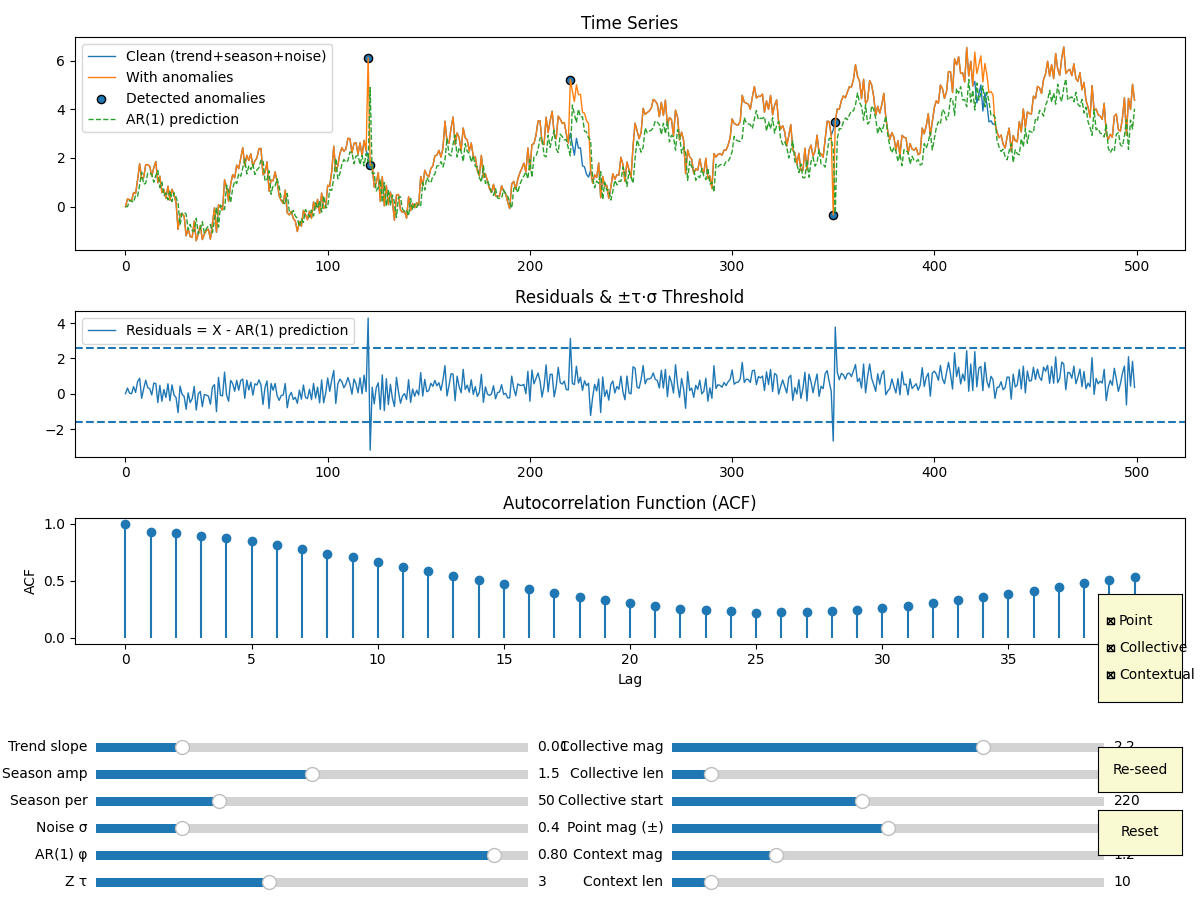

AttributeError: 'NoneType' object has no attribute 'remove'

In [8]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from statsmodels.tsa.stattools import acf

# =========================
# Core generator + detector
# =========================
def synth_series(n=500, seed=7,
                 trend_slope=0.01,
                 season_amp=1.5, season_period=50,
                 noise_sigma=0.4):
    rng = np.random.default_rng(seed)
    t = np.arange(n)
    trend = trend_slope * t
    season = season_amp * np.sin(2*np.pi*t/season_period) if season_period != 0 else 0*t
    noise = noise_sigma * rng.standard_normal(n)
    x_clean = trend + season + noise
    return t, x_clean, trend, season, noise

def inject_anomalies(x, 
                     point_pos=[120, 350], point_mag=[4.0, -3.5],
                     coll_start=220, coll_len=10, coll_mag=2.2,
                     ctxt_start=420, ctxt_len=10, ctxt_mag=1.2,
                     enable_point=True, enable_coll=True, enable_ctxt=True):
    x = x.copy()
    if enable_point and point_pos and point_mag:
        for p, m in zip(point_pos, point_mag):
            if 0 <= p < len(x):
                x[p] += m
    if enable_coll:
        s = max(0, coll_start); e = min(len(x), coll_start + coll_len)
        if s < e:
            x[s:e] += coll_mag
    if enable_ctxt:
        s = max(0, ctxt_start); e = min(len(x), ctxt_start + ctxt_len)
        if s < e:
            x[s:e] += ctxt_mag
    return x

def ar1_forecast(x, phi=None):
    # One-step-ahead AR(1) forecast using either provided phi
    # or a simple plug-in estimate from the series.
    n = len(x)
    pred = np.zeros(n)
    pred[0] = x[0]
    if phi is None:
        # naive plug-in estimate for demo purposes
        num = np.cov(x[1:], x[:-1], bias=True)[0,1]
        den = np.var(x[:-1])
        phi = 0.0 if den == 0 else num/den
    for i in range(1, n):
        pred[i] = phi * x[i-1]
    return pred, phi

def detect_anoms(x, phi=None, z_tau=3.0, lags=40):
    pred, phi_hat = ar1_forecast(x, phi)
    resid = x - pred
    mu = resid.mean()
    sd = resid.std(ddof=0) if resid.std(ddof=0) > 1e-12 else 1.0
    z = (resid - mu) / sd
    idx = np.where(np.abs(z) > z_tau)[0]
    acf_vals = acf(x, nlags=lags, fft=True)
    return dict(pred=pred, phi=phi_hat, resid=resid, z=z, anoms=idx, acf_vals=acf_vals)

# =========================
# Interactive UI
# =========================
def run_demo():
    # Initial params
    n0 = 500
    seed0 = 7
    trend0 = 0.01
    amp0, per0 = 1.5, 50
    noise0 = 0.4
    phi0 = 0.8   # AR(1) coefficient used for *prediction* if set (set None to estimate)
    ztau0 = 3.0

    # anomaly defaults
    ppos0 = [120, 350]; pmag0 = [4.0, -3.5]
    cstart0, clen0, cmag0 = 220, 10, 2.2
    sstart0, slen0, smag0 = 420, 10, 1.2
    enable_point0, enable_coll0, enable_ctxt0 = True, True, True

    # Generate data
    t, x_clean, trend, season, noise = synth_series(
        n=n0, seed=seed0, trend_slope=trend0,
        season_amp=amp0, season_period=per0, noise_sigma=noise0
    )
    x_anom = inject_anomalies(
        x_clean, ppos0, pmag0, cstart0, clen0, cmag0, sstart0, slen0, smag0,
        enable_point0, enable_coll0, enable_ctxt0
    )
    out = detect_anoms(x_anom, phi=phi0, z_tau=ztau0, lags=40)

    # ---- Figure layout
    plt.close('all')
    fig = plt.figure(figsize=(12, 9))
    gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.5, 1.3])

    ax_ts = fig.add_subplot(gs[0, 0])
    ax_resid = fig.add_subplot(gs[1, 0])
    ax_acf = fig.add_subplot(gs[2, 0])

    # Main time series plot
    l_clean, = ax_ts.plot(t, x_clean, lw=1, label='Clean (trend+season+noise)')
    l_anom,  = ax_ts.plot(t, x_anom, lw=1, label='With anomalies')
    scatter = ax_ts.scatter(out["anoms"], x_anom[out["anoms"]], s=35, marker='o', edgecolor='k', label='Detected anomalies')
    l_pred,  = ax_ts.plot(t, out["pred"], lw=1, linestyle='--', label='AR(1) prediction')
    ax_ts.set_title("Time Series")
    ax_ts.legend(loc='upper left')

    # Residual + thresholds
    l_resid, = ax_resid.plot(t, out["resid"], lw=1, label="Residuals = X - AR(1) prediction")
    mu = out["resid"].mean(); sd = out["resid"].std(ddof=0)
    th_up = ax_resid.axhline(mu + ztau0*sd, linestyle='--')
    th_dn = ax_resid.axhline(mu - ztau0*sd, linestyle='--')
    ax_resid.set_title("Residuals & ±τ·σ Threshold")
    ax_resid.legend(loc='upper left')

    # ACF
    stems = ax_acf.stem(range(len(out["acf_vals"])), out["acf_vals"], basefmt=" ")
    ax_acf.set_title("Autocorrelation Function (ACF)")
    ax_acf.set_xlabel("Lag")
    ax_acf.set_ylabel("ACF")

    fig.tight_layout(rect=[0, 0.22, 1, 1])

    # ------------- Controls (Sliders & Buttons)
    axcolor = 'lightgoldenrodyellow'
    ax_trend = plt.axes([0.08, 0.16, 0.36, 0.02], facecolor=axcolor)
    ax_amp   = plt.axes([0.08, 0.13, 0.36, 0.02], facecolor=axcolor)
    ax_per   = plt.axes([0.08, 0.10, 0.36, 0.02], facecolor=axcolor)
    ax_noise = plt.axes([0.08, 0.07, 0.36, 0.02], facecolor=axcolor)
    ax_phi   = plt.axes([0.08, 0.04, 0.36, 0.02], facecolor=axcolor)
    ax_tau   = plt.axes([0.08, 0.01, 0.36, 0.02], facecolor=axcolor)

    s_trend = Slider(ax_trend, 'Trend slope', 0.0, 0.05, valinit=trend0, valstep=0.001)
    s_amp   = Slider(ax_amp,   'Season amp',  0.0, 3.0,   valinit=amp0,   valstep=0.05)
    s_per   = Slider(ax_per,   'Season per',  10,  150,   valinit=per0,   valstep=1)
    s_noise = Slider(ax_noise, 'Noise σ',     0.0, 2.0,   valinit=noise0, valstep=0.05)
    s_phi   = Slider(ax_phi,   'AR(1) φ',    -0.95, 0.95, valinit=phi0,   valstep=0.01)
    s_tau   = Slider(ax_tau,   'Z τ',         1.0, 6.0,   valinit=ztau0,  valstep=0.1)

    # anomaly sliders
    ax_cmag  = plt.axes([0.56, 0.16, 0.36, 0.02], facecolor=axcolor)
    ax_clen  = plt.axes([0.56, 0.13, 0.36, 0.02], facecolor=axcolor)
    ax_cst   = plt.axes([0.56, 0.10, 0.36, 0.02], facecolor=axcolor)
    ax_pmag  = plt.axes([0.56, 0.07, 0.36, 0.02], facecolor=axcolor)
    ax_smag  = plt.axes([0.56, 0.04, 0.36, 0.02], facecolor=axcolor)
    ax_slen  = plt.axes([0.56, 0.01, 0.36, 0.02], facecolor=axcolor)

    s_cmag = Slider(ax_cmag, "Collective mag", -5.0, 5.0, valinit=cmag0, valstep=0.1)
    s_clen = Slider(ax_clen, "Collective len",  1,   100, valinit=clen0, valstep=1)
    s_cst  = Slider(ax_cst,  "Collective start", 0, n0-1, valinit=cstart0, valstep=1)

    s_pmag = Slider(ax_pmag, "Point mag (±)", 0.0, 8.0, valinit=abs(pmag0[0]), valstep=0.1)
    s_smag = Slider(ax_smag, "Context mag",  0.0, 5.0, valinit=smag0, valstep=0.1)
    s_slen = Slider(ax_slen, "Context len",    1,   100, valinit=slen0, valstep=1)

    # toggles: enable anomalies
    rax = plt.axes([0.915, 0.22, 0.07, 0.12], facecolor=axcolor)
    labels = ['Point', 'Collective', 'Contextual']
    visibility = [enable_point0, enable_coll0, enable_ctxt0]
    checks = CheckButtons(rax, labels, visibility)

    # buttons
    bax_reseed = plt.axes([0.915, 0.12, 0.07, 0.05])
    bax_reset  = plt.axes([0.915, 0.05, 0.07, 0.05])
    b_reseed = Button(bax_reseed, 'Re-seed', color=axcolor, hovercolor='0.9')
    b_reset  = Button(bax_reset,  'Reset',   color=axcolor, hovercolor='0.9')

    # internal state
    state = dict(seed=seed0, enable_point=enable_point0, enable_coll=enable_coll0, enable_ctxt=enable_ctxt0)
    
    # Initialize placeholders for outer-scope variables
    scatter = None
    stems = None
    th_up = None
    th_dn = None

    def recompute_and_draw():
        # Rebuild clean series
        t, x_clean2, trend2, season2, noise2 = synth_series(
            n=n0, seed=state['seed'],
            trend_slope=s_trend.val,
            season_amp=s_amp.val,
            season_period=max(2, int(s_per.val)),
            noise_sigma=s_noise.val
        )

        # Anomaly spec: use two symmetric point anomalies around default positions
        pmag = [s_pmag.val, -s_pmag.val]  # symmetric for demo
        x_anom2 = inject_anomalies(
            x_clean2,
            point_pos=ppos0, point_mag=pmag,
            coll_start=int(s_cst.val), coll_len=int(s_clen.val), coll_mag=s_cmag.val,
            ctxt_start=sstart0, ctxt_len=int(s_slen.val), ctxt_mag=s_smag.val,
            enable_point=state['enable_point'], enable_coll=state['enable_coll'], enable_ctxt=state['enable_ctxt']
        )

        # Detect
        out2 = detect_anoms(x_anom2, phi=s_phi.val, z_tau=s_tau.val, lags=40)

        # Update lines & points
        l_clean.set_ydata(x_clean2)
        l_anom.set_ydata(x_anom2)
        l_pred.set_ydata(out2["pred"])

        # update scatter: remove & re-draw for correctness
        for coll in ax_ts.collections:
            if coll is scatter:
                coll.remove()
        new_scatter = ax_ts.scatter(out2["anoms"], x_anom2[out2["anoms"]], s=35, marker='o', edgecolor='k', label='Detected anomalies')

        # Update residuals + thresholds
        l_resid.set_ydata(out2["resid"])
        mu = out2["resid"].mean(); sd = out2["resid"].std(ddof=0)
        for line in [th_up, th_dn]:
            line.remove()
        new_th_up = ax_resid.axhline(mu + s_tau.val*sd, linestyle='--')
        new_th_dn = ax_resid.axhline(mu - s_tau.val*sd, linestyle='--')

        # Update ACF
        for l in stems[0]:
            l.remove()
        for l in stems[1]:
            l.remove()
        new_stems = ax_acf.stem(range(len(out2["acf_vals"])), out2["acf_vals"], basefmt=" ")

        # Rescale Y limits nicely
        ax_ts.relim(); ax_ts.autoscale_view()
        ax_resid.relim(); ax_resid.autoscale_view()
        ax_acf.relim(); ax_acf.autoscale_view()

        fig.canvas.draw_idle()

    # Wire sliders
    for s in [s_trend, s_amp, s_per, s_noise, s_phi, s_tau,
              s_cmag, s_clen, s_cst, s_pmag, s_smag, s_slen]:
        s.on_changed(lambda val: recompute_and_draw())

    # Wire toggles
    def toggle(label):
        if label == 'Point':
            state['enable_point'] = not state['enable_point']
        elif label == 'Collective':
            state['enable_coll'] = not state['enable_coll']
        elif label == 'Contextual':
            state['enable_ctxt'] = not state['enable_ctxt']
        recompute_and_draw()
    checks.on_clicked(toggle)

    # Buttons
    def reseed(event):
        state['seed'] = int(np.random.randint(0, 10_000))
        recompute_and_draw()
    def reset(event):
        s_trend.reset(); s_amp.reset(); s_per.reset(); s_noise.reset()
        s_phi.reset(); s_tau.reset()
        s_cmag.reset(); s_clen.reset(); s_cst.reset()
        s_pmag.reset(); s_smag.reset(); s_slen.reset()
        state['seed'] = seed0
        # Ensure toggles are on
        if not state['enable_point']: checks.set_active(0)
        if not state['enable_coll']: checks.set_active(1)
        if not state['enable_ctxt']: checks.set_active(2)
        state['enable_point'], state['enable_coll'], state['enable_ctxt'] = True, True, True
        recompute_and_draw()
    b_reseed.on_clicked(reseed)
    b_reset.on_clicked(reset)

    plt.show()

# Launch interactive demo
run_demo()


## (Optional) Static Fallback
If widget backends are not available in your environment, run the cell below for a non-interactive, single-shot demonstration with preset parameters.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

np.random.seed(7)
n = 500
t = np.arange(n)
trend = 0.01 * t
season = 1.5 * np.sin(2*np.pi*t/50)
noise = 0.4 * np.random.randn(n)
x = trend + season + noise

# anomalies
x[120] += 4.0
x[350] -= 3.5
x[220:230] += 2.2
x[420:430] += 1.2

# AR(1) forecast
phi = 0.8
pred = np.zeros(n); pred[0] = x[0]
for i in range(1, n): pred[i] = phi * x[i-1]
resid = x - pred
z = (resid - resid.mean()) / resid.std(ddof=0)
anoms = np.where(np.abs(z) > 3.0)[0]

acf_vals = acf(x, nlags=40, fft=True)

plt.figure(figsize=(11, 3.5))
plt.plot(t, x, label='Series with anomalies')
plt.plot(t, pred, linestyle='--', label='AR(1) prediction')
plt.scatter(anoms, x[anoms], s=35, marker='o', edgecolor='k', label='Detected anomalies')
plt.legend(); plt.title('Time Series, Prediction, and Detected Anomalies'); plt.tight_layout(); plt.show()

plt.figure(figsize=(11,3.5))
plt.plot(t, resid, label='Residuals')
plt.axhline(resid.mean()+3*resid.std(ddof=0), linestyle='--')
plt.axhline(resid.mean()-3*resid.std(ddof=0), linestyle='--')
plt.legend(); plt.title('Residuals & ±3σ Threshold'); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3.5))
plt.stem(range(len(acf_vals)), acf_vals, basefmt=' ')
plt.title('Autocorrelation Function (ACF)'); plt.xlabel('Lag'); plt.ylabel('ACF'); plt.tight_layout(); plt.show()
